In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import numpy as np
from scipy.spatial import distance_matrix

import astropy.units as u
import os
import glob
# This makes nice big plots for matplotlib
import matplotlib as mpl
params = {'font.size': 14,
          'figure.figsize': (15.0, 8.0),
          'lines.linewidth': 2.,
          'lines.markersize': 15,
          'animation.embed_limit': 2048,
          }
mpl.rcParams.keys()
mpl.rcParams.update(params)
np.set_printoptions(suppress=True)

import sunpy.map

data_dir = os.path.abspath("/home/lazar/Fak(s)/AF/prakse/SDSA/data")

cont_list = sorted(glob.glob(os.path.join(
    data_dir, "3481_11923_SHARP_CEA_enhanced_norm/*enhanced_normalized*")))


magnetic_data_dir = os.path.join(
    data_dir, "3481_11923_SHARP_CEA_upscaled_magnetic_data")
Br_list = sorted(glob.glob(os.path.join(
    magnetic_data_dir, "*Br*")))
Bp_list = sorted(glob.glob(os.path.join(
    magnetic_data_dir, "*Bp*")))
Bt_list = sorted(glob.glob(os.path.join(
    magnetic_data_dir, "*Bt*")))
patches_dir = os.path.join(data_dir, "3481_11923_SHARP_CEA_patches")
patches_list = sorted(glob.glob(os.path.join(patches_dir, "*patches*")))

In [19]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
#This so i can fetch this function which is in directory above
from region_fill_master_wrap import get_patches_and_vectors
from skimage.feature import match_descriptors

In [20]:
help(get_patches_and_vectors)

Help on function get_patches_and_vectors in module region_fill_master_wrap:

get_patches_and_vectors(I, bx, by, bz, pixel_limit=20, thr=0.5, floodfill=4)
    I - intensity map for detecting pores; should be normalized to quiet sun
    bx - bx data (should be Bp from sharps) type should be sunpy map
    by - by data (should be Bt from sharps) type should be sunpy map. DO NOT CHANGE SIGN OF DATA, THIS FUNCTION WILL DO IT!
    bz - bz data (should be Br from sharps) type should be sunpy map
    pixel_limit - ignore patches that are smaller than this size
    thr - if I < thr => we assign it as pixel of interes; if data is normalized, 0.5 should work
    floodfill - in how many direction structure should perform flood fill
    https://en.wikipedia.org/wiki/Flood_fill
    
    floodfill = 4 looks in 4 direction and search structure looks like this
       [[0,1,0],
        [1,1,1],
        [0,1,0]]
    
    floodfill = 8 looks in 8 direction and search structure looks like this
        [[1,1

In [21]:
cmasses, _ = get_patches_and_vectors(sunpy.map.Map(cont_list[650]), 
                        sunpy.map.Map(Bp_list[650]), 
                        sunpy.map.Map(Bt_list[650]), 
                        sunpy.map.Map(Br_list[650]), pixel_limit=25)

Using 4 directions search map on HMI hmi 2013-12-13 21:10:09


In [22]:
print(np.loadtxt(patches_list[650]))
print(cmasses)

[[ 1139.52238806   592.          -215.23507908  -231.39415137
  -1320.33331954    67.        ]
 [ 1130.14285714   613.20571429  -191.71509699  -463.3988206
  -1647.18270998   175.        ]
 [  948.2          675.00740741   501.57266708    92.17912835
   1480.04186609   135.        ]
 [  936.60869565   671.60869565   227.75444014  -376.75290841
   1578.75588182    23.        ]
 [  929.19047619   673.04761905  -105.23079053  -318.0144968
   1514.06757042    21.        ]
 [  830.73076923   682.03846154  -383.74010477   136.96013992
   1309.80831902    26.        ]
 [  936.25         680.85          45.56766789   248.89492558
   1829.64629229    20.        ]
 [  847.20940171   688.31623932   -30.22556229   146.4120374
   1710.48048017   234.        ]]
[[ 1139.52238806   592.          -215.23507908  -231.39415137
  -1320.33331954    67.        ]
 [ 1130.14285714   613.20571429  -191.71509699  -463.3988206
  -1647.18270998   175.        ]
 [  948.2          675.00740741   501.57266708    92.

In [23]:
#plt.imshow(regioni)

## Define 2D gaussian window

In [24]:
def gauss2dwindow(cent, sigma, dim):
    x, y = np.meshgrid(np.linspace(0,dim[1],dim[1]), np.linspace(0,dim[0],dim[0]))
    g = np.exp(-( ((x-cent[0])**2) / ( 2.0 * sigma[0]**2 ) + ((y-cent[1])**2) / ( 2.0 * sigma[1]**2 ) ))
    return g

In [25]:
#plt.figure(size='same')
#gauss2dwindow([400,400],[5,5], [1000,1500]).shape
#plt.colorbar()

In [26]:
start = 582
plim = 20
I1 = sunpy.map.Map(cont_list[start])
I2 = sunpy.map.Map(cont_list[start+1])
I3 = sunpy.map.Map(cont_list[start+2])
centers_1, region_map_1 = get_patches_and_vectors(sunpy.map.Map(cont_list[start]),
                                                  sunpy.map.Map(
                                                      Bp_list[start]),
                                                  sunpy.map.Map(
                                                      Bt_list[start]),
                                                  sunpy.map.Map(Br_list[start]), pixel_limit=plim, floodfill=4)

centers_2, region_map_2 = get_patches_and_vectors(sunpy.map.Map(cont_list[start+1]),
                                                  sunpy.map.Map(
                                                      Bp_list[start+1]),
                                                  sunpy.map.Map(
                                                      Bt_list[start+1]),
                                                  sunpy.map.Map(Br_list[start+1]), pixel_limit=plim, floodfill=4)

centers_3, region_map_3 = get_patches_and_vectors(sunpy.map.Map(cont_list[start+2]),
                                                  sunpy.map.Map(
                                                      Bp_list[start+2]),
                                                  sunpy.map.Map(
                                                      Bt_list[start+2]),
                                                  sunpy.map.Map(Br_list[start+2]), pixel_limit=plim, floodfill=4)

#box edge for LCT



Using 4 directions search map on HMI hmi 2013-12-13 07:34:09
Using 4 directions search map on HMI hmi 2013-12-13 07:46:09
Using 4 directions search map on HMI hmi 2013-12-13 07:58:09


# This kind of does not work, LCT

In [27]:
#box_edge = 40
#region = 4
#from skimage.feature import match_template

#gauss_mask = gauss2dwindow([centers_1[region,0],centers_1[region,1]], [10,10], region_map_1.shape)


#lets extract padding around gaussian (slightly larger that 40pix)
#xx = (int(centers_1[region,0]-box_edge/2), int(centers_1[region,0]+box_edge/2))
#yy = (int(centers_1[region,1]-box_edge/2), int(centers_1[region,1]+box_edge/2))


#region_map_1[region_map_1>0] = 1
#region_map_1 = I1.data
#region_map_2 = I2.data

#traces = region_map_1*gauss_mask

#template = traces[yy[0]:yy[1],xx[0]:xx[1]]

#plt.figure(0)
#plt.imshow(template, origin='lower')
#print(template.shape)
#plt.imshow(template)

#result = match_template(region_map_2, template)


#plt.imshow(result,origin='lower')



#print(np.unique(result))
#ij = np.unravel_index(np.argmax(result), result.shape)
#x, y = ij[::-1]

#print(x,y)
#plt.scatter(x,y,zorder=10, marker='x', color='r')
#plt.colorbar()



#fig = plt.figure(1)
#ax = fig.add_subplot(111)
#plt.xlim([800, 1200])
#plt.ylim([500, 700])
#plt.imshow(region_map_1*gauss_mask, zorder=0, cmap='gray')
#plt.imshow(region_map_1, zorder=0)
#plt.scatter(x,y,zorder=1,marker='^', color='g')
#plt.scatter(centers_1[:, 0], centers_1[:, 1], zorder=1, marker='x', color='r')
#for i in range(centers_1.shape[0]):
#    ax.add_patch(Rectangle((centers_1[i, 0]-box_edge/2, centers_1[i, 1]-box_edge/2), box_edge, box_edge,
#                           fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))

# print(centers_1)
#fig2 = plt.figure(2)
#ax2 = fig2.add_subplot(111)
#plt.xlim([800, 1200])
#plt.ylim([500, 700])
#plt.imshow(region_map_2, zorder=0)
#plt.scatter(centers_2[:, 0], centers_2[:, 1], zorder=1, marker='x', color='r')
#plt.scatter(895,653, zorder=1, marker='x', color='r')

#for i in range(centers_2.shape[0]):
#    ax2.add_patch(Rectangle((centers_2[i, 0]-box_edge/2, centers_2[i, 1]-box_edge/2), box_edge, box_edge,
#                            fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))

In [28]:
def find_nearest(poi, centers, search_radii=20):
    #point of interest
    #all centers on different image
    
    #
    #dist_box = search_radii*np.sqrt(2)
    dist_matrix = np.sqrt( (poi[0]-centers[:,0])**2 + (poi[1]-centers[:,1])**2 )
    
    candidates = np.argwhere(dist_matrix <= search_radii)
    print(candidates)
    if candidates.size == 0:
        print('no candidates')
    return None
    

C1 = np.dstack((centers_1[:, 0], centers_1[:, 1]))[0]
print(C1)
C2 = np.dstack((centers_2[:, 0], centers_2[:, 1]))[0]
print(C2)
from scipy.optimize import linear_sum_assignment
print(distance_matrix(C1,C2))
print(linear_sum_assignment(distance_matrix(C1,C2)))
ZZ = linear_sum_assignment(distance_matrix(C1,C2))
print(ZZ[0])
#print(sp)

[[1117.48958333  596.72916667]
 [1099.24242424  616.01515152]
 [ 866.6302521   657.24369748]
 [ 852.75        651.4       ]
 [ 933.92592593  683.96296296]]
[[1118.71764706  596.41176471]
 [1099.90789474  616.22368421]
 [ 869.54347826  650.84782609]
 [ 864.23376623  662.74025974]
 [ 934.03125     683.90625   ]]
[[  1.26841812  26.25170448 253.78356983 261.71735384 203.11770954]
 [ 27.63289848   0.69737857 232.3250331  239.60864984 178.61672192]
 [259.32330929 236.85670783   7.0280906    5.99627728  72.48300645]
 [271.59251702 249.64854921  16.80255362  16.13934255  87.5402644 ]
 [204.48274381 179.27248494  72.39966752  72.85190632   0.11962241]]
(array([0, 1, 2, 3, 4]), array([0, 1, 3, 2, 4]))
[0 1 2 3 4]


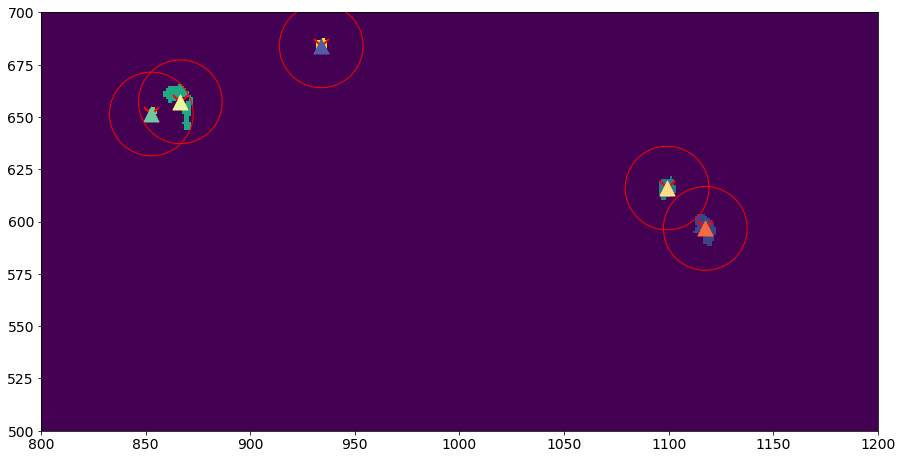

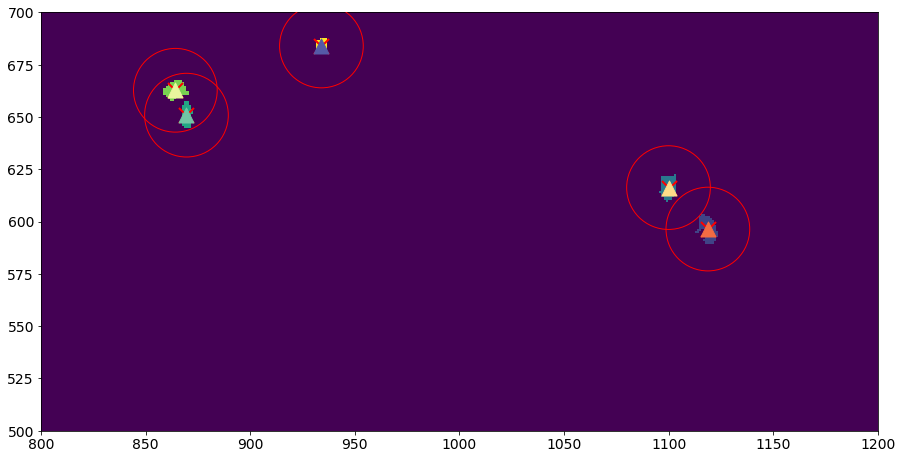

In [29]:
fig = plt.figure(0)
ax = fig.add_subplot(111)
plt.xlim([800, 1200])
plt.ylim([500, 700])
plt.imshow(region_map_1, zorder=0)

counter = 0
for i in ZZ[0]:
    #print(i)
    counter+=1
    plt.scatter(centers_1[i, 0], centers_1[i, 1], zorder=10, marker='^', color=plt.cm.Spectral(counter*50))

plt.scatter(centers_1[:, 0], centers_1[:, 1], zorder=1, marker='x', color='r')
#plt.scatter(centers_2[:, 0], centers_2[:, 1], zorder=1, marker='x', color='b')

for i in range(centers_1.shape[0]):
    ax.add_patch(Circle((centers_1[i, 0], centers_1[i, 1]), 20,
                           fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))

#find_nearest((centers_1[3, 0], centers_1[3, 1]), centers_2)

fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.xlim([800, 1200])
plt.ylim([500, 700])
plt.imshow(region_map_2, zorder=0)
#plt.scatter(x,y,zorder=1,marker='^', color='g')


plt.scatter(centers_2[:, 0], centers_2[:, 1], zorder=1, marker='x', color='r')
#plt.scatter(centers_2[3,0], centers_2[3,1], zorder=10, marker='^')
#plt.scatter(centers_1[:, 0], centers_1[:, 1], zorder=1, marker='x', color='b')
counter=0
for i in ZZ[1]:
    counter+=1
    plt.scatter(centers_2[i, 0], centers_2[i, 1], zorder=10, marker='^', color=plt.cm.Spectral(counter*50))

for i in range(centers_2.shape[0]):
    ax.add_patch(Circle((centers_2[i, 0], centers_2[i, 1]), 20,
                           fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))
    
    

Using 4 directions search map on HMI hmi 2013-12-13 11:10:09
Using 4 directions search map on HMI hmi 2013-12-13 11:22:09
Using 4 directions search map on HMI hmi 2013-12-13 11:34:09
Using 4 directions search map on HMI hmi 2013-12-13 11:46:09
Using 4 directions search map on HMI hmi 2013-12-13 11:58:09


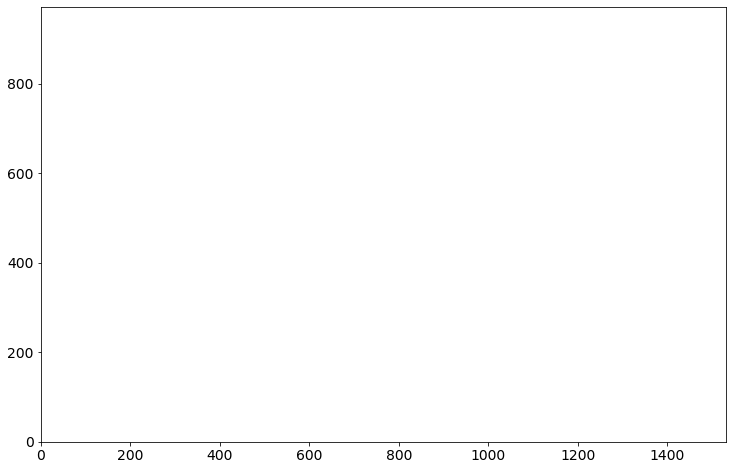

In [30]:
from celluloid import Camera
#Create placeholders for canvas
fig, ax = plt.subplots()
camera = Camera(fig)
#Fix canvas size (because data dimension changes with time)
#plt.xlim([700, 1200])
#plt.ylim([500, 800])


#for start in range(627,632):
for start in range(600,605):
    centers_1, region_map_1 = get_patches_and_vectors(sunpy.map.Map(cont_list[start]),
                                                  sunpy.map.Map(
                                                      Bp_list[start]),
                                                  sunpy.map.Map(
                                                      Bt_list[start]),
                                                  sunpy.map.Map(Br_list[start]), pixel_limit=plim, floodfill=4)
    #print(centers_1.ndim)

    plt.imshow(region_map_1, zorder=0, origin='lower')
    #plt.scatter(centers_1[:, 0], centers_1[:, 1], zorder=1, marker='x', color='r')
    #plt.legend(loc='best')
    plt.text(100,100,str(start))
    if centers_1.ndim == 0:
        camera.snap()
        continue
    for i in range(centers_1.shape[0]):
        ax.add_patch(Circle((centers_1[i, 0], centers_1[i, 1]), 20,
                           fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))
    
    camera.snap()
    #plt.cla()

animation = camera.animate(interval=200)
#animation.save('all_circles_contours.mp4')


#uncomment this for live preview in jupyter notebook
from IPython.display import HTML
HTML(animation.to_html5_video())


# Track [600-605) look at video above

In [157]:
#for start in range(600,605):
start = 550
many = 100
#Saves memory, maybe you will want also real maps loaded, but no need AFAIK
I_maps = cont_list[start:start+many]
Bx_maps = Bp_list[start:start+many]
By_maps = Bt_list[start:start+many]
Bz_maps = Br_list[start:start+many]
#Dont load it in for, hate doing that, create lambda wrapper
g = lambda i,x,y,z: get_patches_and_vectors(sunpy.map.Map(i), sunpy.map.Map(x), 
                                            sunpy.map.Map(y), sunpy.map.Map(z), 
                                            pixel_limit=plim, floodfill=4)
DATA = np.asarray(list(map(g, I_maps, Bx_maps, By_maps, Bz_maps)))

Using 4 directions search map on HMI hmi 2013-12-13 01:10:09
Using 4 directions search map on HMI hmi 2013-12-13 01:22:09
Using 4 directions search map on HMI hmi 2013-12-13 01:34:09
Using 4 directions search map on HMI hmi 2013-12-13 01:46:09
Using 4 directions search map on HMI hmi 2013-12-13 01:58:09
Using 4 directions search map on HMI hmi 2013-12-13 02:10:09
Using 4 directions search map on HMI hmi 2013-12-13 02:22:09
Using 4 directions search map on HMI hmi 2013-12-13 02:34:09
Using 4 directions search map on HMI hmi 2013-12-13 02:46:09
Using 4 directions search map on HMI hmi 2013-12-13 02:58:09
Using 4 directions search map on HMI hmi 2013-12-13 03:10:09
Using 4 directions search map on HMI hmi 2013-12-13 03:22:09
Using 4 directions search map on HMI hmi 2013-12-13 03:34:09
Using 4 directions search map on HMI hmi 2013-12-13 03:46:09
Using 4 directions search map on HMI hmi 2013-12-13 03:58:09
Using 4 directions search map on HMI hmi 2013-12-13 04:10:09
Using 4 directions searc

<Figure size 1080x576 with 0 Axes>

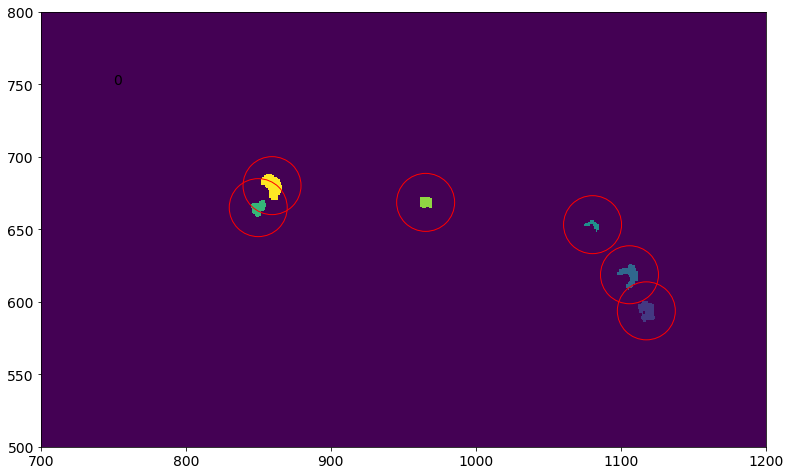

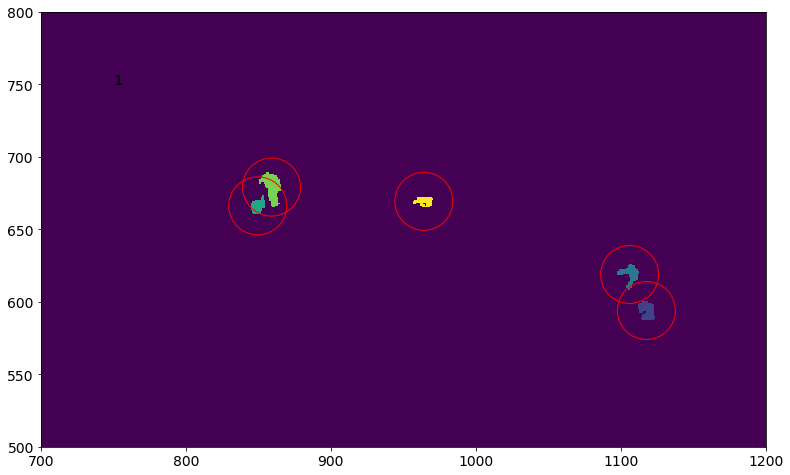

In [32]:
#print(DATA)
#DATA[:,0] - returns all centers
#DATA[:,1] - returns all maps

for start in range(0,2):
    C1 = np.dstack((DATA[start,0][:,0],DATA[start,0][:,1]))[0]
    C2 = np.dstack((DATA[start+1,0][:,0],DATA[start+1,0][:,1]))[0]
    #Cs = np.dstack((DATA[start,0][:,0],DATA[start,0][:,1]))[0]
    #Ce = np.dstack((DATA[start+1,0][:,0],DATA[start+1,0][:,1]))[0]
    #print(C1)
    fig = plt.figure(start)
    _, ax = plt.subplots()
    plt.xlim([700, 1200])
    plt.ylim([500, 800])
    plt.imshow(DATA[start,1])
    plt.text(750,750,str(start))
    for x,y in zip(DATA[start,0][:,0],DATA[start,0][:,1]):
        ax.add_patch(Circle((x, y), 20,
                        fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))
        

[[  0.27627929  26.40907192  66.05278045 274.40144421 171.00065764
  210.99692004]
 [ 27.70092773   1.10501668  39.08171537 256.78306934 150.53836481
  190.29696527]
 [277.91325434 261.80013892 232.69635253  10.87037112 115.06242775
   82.34088448]
 [272.47486631 255.19835265 224.51730467   5.25887774 105.82927969
   70.3740088 ]
 [171.27939198 151.66243777 119.17311557 108.73210447   0.84517688
   39.9950785 ]]
Ovaj jeste
0 0
Ovaj jeste
1 1
Ovaj nije mapiran!
Nestao je
2 3
Ovaj nije mapiran!
Nestao je
3 3
Ovaj jeste
4 4


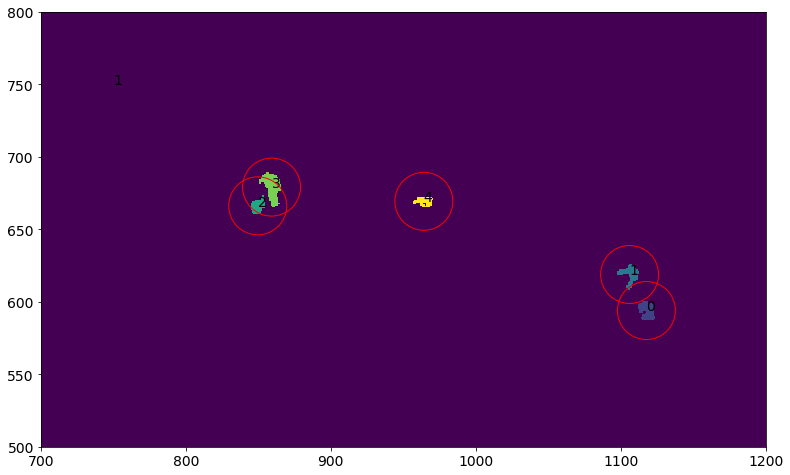

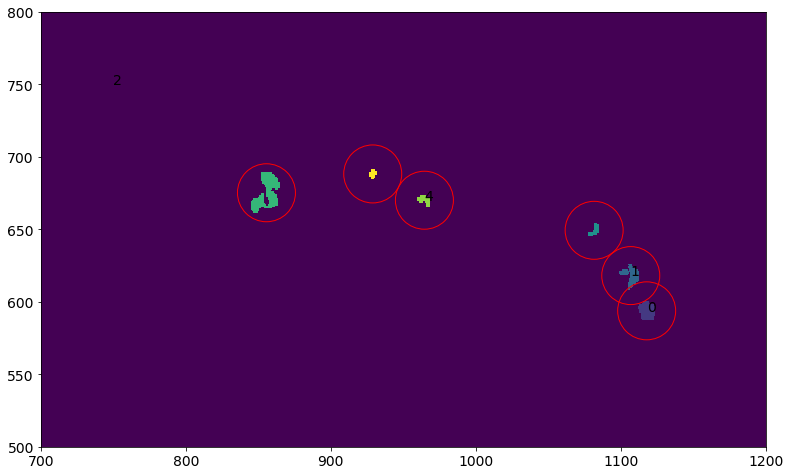

In [33]:
C1 = np.dstack((DATA[1,0][:,0],DATA[1,0][:,1]))[0]

fig, ax = plt.subplots(1)

plt.xlim([700, 1200])
plt.ylim([500, 800])
plt.imshow(DATA[1,1])
for x,y in zip(DATA[1,0][:,0],DATA[1,0][:,1]):
    ax.add_patch(Circle((x, y), 20,
                        fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none'))

#plt.text(C2[:,0], C2[:,1],str(prvi))
plt.text(750,750,str(start))

for i in range(C1.shape[0]):
    plt.text(C1[i,0], C1[i,1],str(i))



fig1, ax1 = plt.subplots(1)
plt.xlim([700, 1200])
plt.ylim([500, 800])
plt.imshow(DATA[2,1])
for x,y in zip(DATA[2,0][:,0],DATA[2,0][:,1]):
    ax1.add_patch(Circle((x, y), 20,
                        fill=False, zorder=10, linewidth=1, edgecolor='r', facecolor='none')) 
plt.text(750,750,str(start+1))


C2 = np.dstack((DATA[2,0][:,0],DATA[2,0][:,1]))[0]
from scipy.optimize import linear_sum_assignment
print(distance_matrix(C1,C2))

DM = distance_matrix(C1,C2)
ZZ = linear_sum_assignment(DM)
for prvi in range(DM.shape[0]):
    #print(DM[prvi])
    drugi = np.argmin(DM[prvi])
    if DM[prvi, drugi] > 2:
        print('Ovaj nije mapiran!')
        print('Nestao je')
        print(prvi, drugi)
        
    else:
        print('Ovaj jeste')
        print(prvi, drugi)
        plt.text(C2[drugi,0], C2[drugi,1],str(prvi))

#dataset, part (centers,region), row, column
#print(DATA[0,0][0,0])

[array([[ 1117.70588235,   593.78151261,   -68.25962172,   -84.46813462,
        -1458.83438938,   119.        ],
       [ 1106.08547009,   618.68376068,   -39.12366872,  -334.07866219,
        -1380.46947059,   117.        ],
       [ 1080.60606061,   653.24242424,   101.74636787,  -554.95448184,
        -1177.04093256,    33.        ],
       [  849.97590361,   664.98795181,  -256.09286144,  -256.61966711,
         1420.30701304,    83.        ],
       [  965.46666667,   668.61666667,   465.23484708,   -28.91145659,
         1292.2892163 ,    60.        ],
       [  859.49101796,   680.16167665,   -93.8863398 ,   231.60218204,
         1693.57334469,   167.        ]])
 array([[ 1117.74782609,   594.        ,   -71.93502036,   -84.86601993,
        -1485.71389388,   115.        ],
       [ 1106.16964286,   618.875     ,    -2.32379305,  -373.39487972,
        -1380.17999698,   112.        ],
       [  849.62068966,   666.20689655,  -272.72768133,  -229.84113576,
         1443.6581160

IndexError: too many indices for array

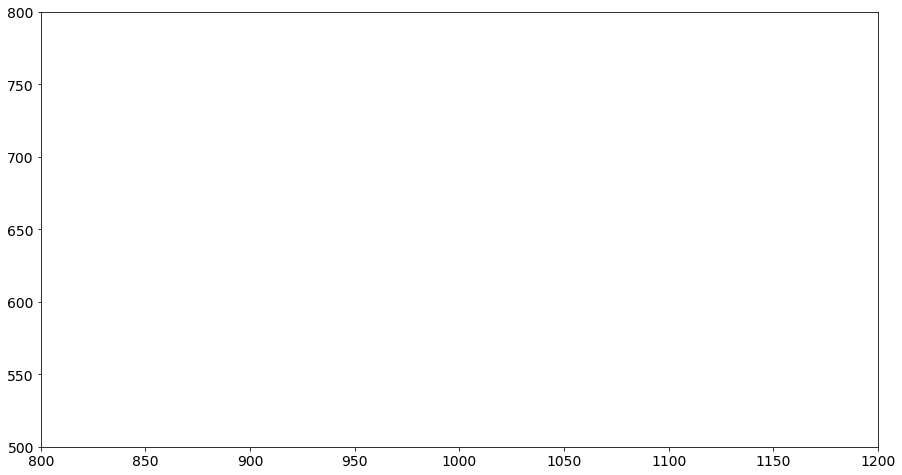

In [35]:
plt.xlim([800, 1200])
plt.ylim([500, 800])
tracked=DATA[:,0]#[0,0]# - returns all centers
print(DATA[:,0])

#plt.scatter(tracked[:,0],tracked[:,1], zorder=1, color='r', marker='x')
from sklearn.cluster import DBSCAN
from sklearn import metrics
X = np.dstack((tracked[:,0],tracked[:,1]))[0]
#print(X[0])
#This is working OK detecting mergers!
#Now how to find unmergers it works
db = DBSCAN(eps=15, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [233]:
start = 600
many = 1
I = sunpy.map.Map(cont_list[start])
I2 = sunpy.map.Map(cont_list[start+1])

from matplotlib.patches import ConnectionPatch

#print(cont_list[start])
#from skimage.morphology import black_tophat, white_tophat
C1, region_map_1 = get_patches_and_vectors(sunpy.map.Map(cont_list[start]),
                                                  sunpy.map.Map(
                                                      Bp_list[start]),
                                                  sunpy.map.Map(
                                                      Bt_list[start]),
                                                  sunpy.map.Map(Br_list[start]), pixel_limit=plim, floodfill=4)

C2, region_map_2 = get_patches_and_vectors(sunpy.map.Map(cont_list[start+1]),
                                                  sunpy.map.Map(
                                                      Bp_list[start+1]),
                                                  sunpy.map.Map(
                                                      Bt_list[start+1]),
                                                  sunpy.map.Map(Br_list[start+1]), pixel_limit=plim, floodfill=4)




def map_between_images(centers_1, centers_2, r_search=15):
    '''
    C1 - Matrix of centers that get_patches_and_vectors returns
    C2 - Matrix of centers that get_patches_and_vectors returns for second image
    r_search - search radius for nearest neighbour in pixel distance
    - it search for 
    
    returns:
    mapper - Array of tuples containing mappings between two images
    first element of tuple is patch on first image
    '''
    mapper = [] #Fucking hate doing append and empty array creation!
    
    #if centers_1 have no entries
    #Return empty array
    if centers_1.ndim == 0:
        return mapper
    
    #If it has something, extract X and Y coordinates
    C1 = centers_1[:,0:2]
    
    #if centers_2 have no entries
    #we know that everything from first image dissapeared
    #so we return tuples (cent_1, 'X')
    if centers_2.ndim == 0:
        #i know that center_1.ndim != 0
        #bcz of above if
        for i in range(C1.shape[0]):
            mapper.append((i, 'X'))
        return mapper
    
    C2 = centers_2[:,0:2]
    #Calculate distance matrix
    DM = distance_matrix(C1,C2)
    
    #Loop trough all rows of cost matrix 
    for prvi in range(DM.shape[0]):
        #if in that row, we have entries that are smaller than r_search
        #we put it in tuple
        drugi = (DM[prvi] < r_search).nonzero()[0]
        #If there is no entries, mark it as NOT MAPPED (disapeared or whatever)
        
        
        if drugi.shape[0] == 0:
            #print("ovaj nije mapiran")
            mapper.append((prvi, 'X'))
            #Skip that row for executing on code bellow
            continue
        #If we have multiple values (or signle, we dont care)
        #mark those as MAPPED
        for i in drugi:
            mapper.append((prvi,i))
            
    #I need one more check
       
    #Imagine you have two points in C1 and two in C2
    #Distance C1_1 to C2_1 and C2_2 are both < r_search
    #This will say:
    #"ok, C1_1 is mapped into both C2_1 and C2_2 and C1_2 also maps into C2_1 and C2_2"
        
            
    return mapper

#print(DATA.shape)

#maps = 


"""

"""

print(DATA[:,0].shape[0])
#all_centers = DATA[:,0]
mapper = []
for i in range(DATA[:,0].shape[0]-1):
    #print(i)
    C1 = DATA[:,0][i]
    C1 = DATA[:,0][i+1]
    mapper.append(map_between_images(C1,C2,r_search=11))

mapper
#print(list(zip(*mapper))[0])

Using 4 directions search map on HMI hmi 2013-12-13 11:10:09
Using 4 directions search map on HMI hmi 2013-12-13 11:22:09
100


[[(0, 'X'), (1, 'X'), (2, 4), (3, 'X')],
 [(0, 'X'), (1, 4), (2, 'X')],
 [(0, 'X'), (1, 4), (2, 'X')],
 [(0, 0), (1, 4), (2, 'X')],
 [(0, 'X'), (1, 0), (2, 4), (3, 'X')],
 [(0, 'X'), (1, 0), (2, 4), (3, 'X')],
 [(0, 'X'), (1, 4), (2, 'X')],
 [(0, 'X'), (1, 4), (2, 'X')],
 [(0, 'X'), (1, 'X'), (2, 'X')],
 [(0, 'X'), (1, 'X'), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X')],
 [(0, 'X'), (1, 'X'), (2, 'X'), (3, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X'), (5, 'X')],
 [(0, 'X'), (1, 0), (2, 'X'), (3, 'X'), (4, 'X'), (5, 'X')

[(0, 0), (1, 'X'), (2, 4), (3, 'X')]
(0, 1, 2, 3)
(0, 'X', 4, 'X')


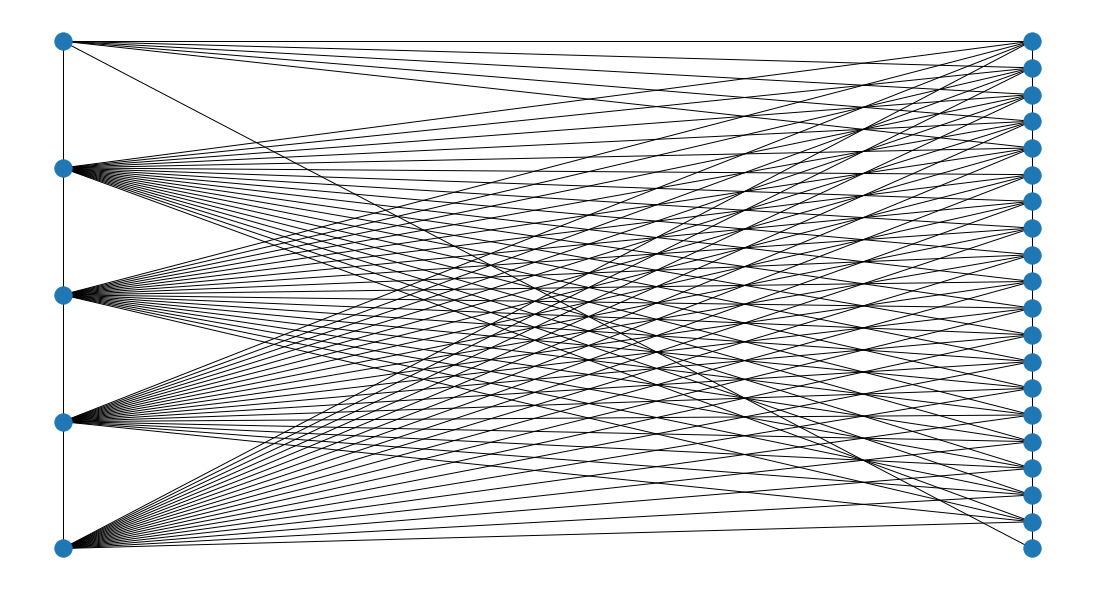

In [225]:
print(mapper[0])
print(list(zip(*mapper[0]))[0])
print(list(zip(*mapper[0]))[1])
B = nx.DiGraph()

import networkx as nx
G = nx.complete_multipartite_graph(5, 15, 5)
#G.nodes[u]['subset'] for u in G]





#B.add_nodes_from(['a','b','c'])
#B.add_nodes_from([3,2,1])
#B.add_nodes_from([4,5,6])

#B.add_nodes_from([3,2,1])
#B.add_nodes_from(['a','b','c'])


#B.add_edges_from([('a',2), ('b',2), ('c',3)])
#B.add_edges_from([(2,4), (2,5), (1,6)])
#B.add_edges_from([('a',4), ('b',2), ('c',3)])

pos = nx.bipartite_layout(G, [1,2,3,4,5], align='vertical')
#pos = nx.planar_layout(B)
nx.draw(G, pos)

Using 4 directions search map on HMI hmi 2013-12-13 15:10:09
Using 4 directions search map on HMI hmi 2013-12-13 15:22:09
Ovaj jeste
0 0
Ovaj jeste
1 1
Ovaj jeste
2 2
Ovaj jeste
2 3
Ovaj jeste
3 4
Ovaj jeste
4 6
Ovaj jeste
5 5
Ovaj jeste
6 6
mapper:  [(0, 0), (1, 1), (2, 2), (2, 3), (3, 4), (4, 6), (5, 5), (6, 6)]
mapper1:  [(0, 0), (1, 1), (2, 2), (2, 3), (3, 4), (4, 6), (5, 5), (6, 6)]
(1120.0, 593.4823529411765)
(1120.231884057971, 593.8695652173913)
0 0
1 1
2 2
2 3
3 4
4 6
5 5
6 6


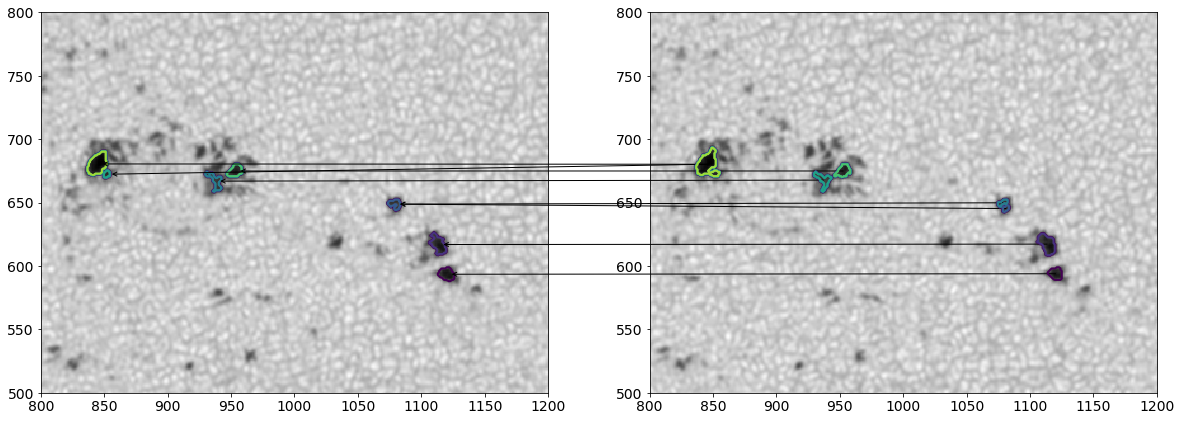

In [234]:
start = 620
many = 1
I = sunpy.map.Map(cont_list[start])
I2 = sunpy.map.Map(cont_list[start+1])

from matplotlib.patches import ConnectionPatch

#print(cont_list[start])
#from skimage.morphology import black_tophat, white_tophat
C1, region_map_1 = get_patches_and_vectors(sunpy.map.Map(cont_list[start]),
                                                  sunpy.map.Map(
                                                      Bp_list[start]),
                                                  sunpy.map.Map(
                                                      Bt_list[start]),
                                                  sunpy.map.Map(Br_list[start]), pixel_limit=plim, floodfill=4)

C2, region_map_2 = get_patches_and_vectors(sunpy.map.Map(cont_list[start+1]),
                                                  sunpy.map.Map(
                                                      Bp_list[start+1]),
                                                  sunpy.map.Map(
                                                      Bt_list[start+1]),
                                                  sunpy.map.Map(Br_list[start+1]), pixel_limit=plim, floodfill=4)




C1 = C1[:,0:2]
C2 = C2[:,0:2]

DM = distance_matrix(C1,C2)
mapper = []
r_search = 11 # pix of distance
for prvi in range(DM.shape[0]):
    #print(DM[prvi])
    #drugi = np.argmin(DM[prvi])
    #fetch all that are less than 11
    drugi = (DM[prvi] < r_search).nonzero()[0]
    if drugi.shape[0] == 0:
        print("ovaj nije mapiran")
        mapper.append((prvi, 'X'))
        continue
    for i in drugi:
        print('Ovaj jeste')
        print(prvi, i)
        mapper.append((prvi,i))

mapper1 = map_between_images(C1,C2,r_search=11)


print('mapper: ', mapper)
print('mapper1: ', mapper1)
mask = np.ma.masked_where((I.data <= thr) & (I.data > 0), I.data)
mask2 = np.ma.masked_where((I2.data <= thr) & (I2.data > 0), I2.data)
#plt.imshow(white_tophat(I.data), cmap='gray', origin='lower')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#axes[0] = plt.subplot(1, 2, 1)
ax1.imshow(I.data, cmap='gray', origin='lower')
ax1.contour(region_map_1)
ax1.set_xlim([800,1200])
ax1.set_ylim([500,800])

# Draw an arrow between the same point in data coordinates,
# but in different axes.
map_between_images
#WHAT PATCH!
ptch = 0
#which region on first?
a1 = mapper[ptch][0]
#which region on second?
a2 = mapper[ptch][1]
#print(a1,a2)
#get xy data from first patch
xya = (C1[a1,0], C1[a1,1])
#get xy data from second patch
xyb = (C2[a2,0], C2[a2,1])
print(xya)
print(xyb)

for p1, p2 in mapper:
    print(p1,p2)
    if p1 == 'X' or p2 == 'X':
        continue
    xya = (C1[p1,0], C1[p1,1])
    xyb = (C2[p2,0], C2[p2,1])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA=xyb, xyB=xya, coordsA=coordsA, coordsB=coordsB,
                      axesA=ax2, axesB=ax1,
                      arrowstyle="->", shrinkB=5)
    ax2.add_artist(con)



#axes[1] = plt.subplot(1, 2, 2)
ax2.set_xlim([800, 1200])
ax2.set_ylim([500, 800])
ax2.imshow(I2.data, cmap='gray', origin='lower')
ax2.contour(region_map_2)
plt.savefig('3.jpg')
#Bx_maps = Bp_list[start:start+many]
#By_maps = Bt_list[start:start+many]
#Bz_maps = Br_list[start:start+many]
#Dont load it in for, hate doing that, create lambda wrapper
#g = lambda i,x,y,z: get_patches_and_vectors(sunpy.map.Map(i), sunpy.map.Map(x), 
                                            #sunpy.map.Map(y), sunpy.map.Map(z), 
                                            #pixel_limit=plim, floodfill=4)